In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from tqdm import tqdm

from transformers import (
    BertModel,
    BertTokenizer
)

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
DATA_PATH = 'data/train.csv'
RANDOM_STATE = 42
MODEL = 'bert-base-multilingual-cased'

In [4]:
tqdm.pandas()
sns.set_theme()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
df = pd.read_csv(DATA_PATH)
df.head()

,text,class
0,проблема: не открывается АКТ сверки по СБС № П...,1-46
1,В случае выбора неверного шаблона просьба указ...,1-70
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28


In [6]:
model = BertModel.from_pretrained(MODEL).to(device)
tokenizer = BertTokenizer.from_pretrained(MODEL, do_lower_case=True)

In [7]:
def embed(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    X = model(**encoded_input)
    return X.last_hidden_state[:, 0, :]

In [8]:
text = df.loc[0, 'text']
embedding = embed(text)
embedding.shape

torch.Size([1, 768])

In [9]:
df['embedding'] = df['text'].progress_apply(lambda text: embed(text).cpu().detach())

100%|██████████| 15449/15449 [05:50<00:00, 44.10it/s]


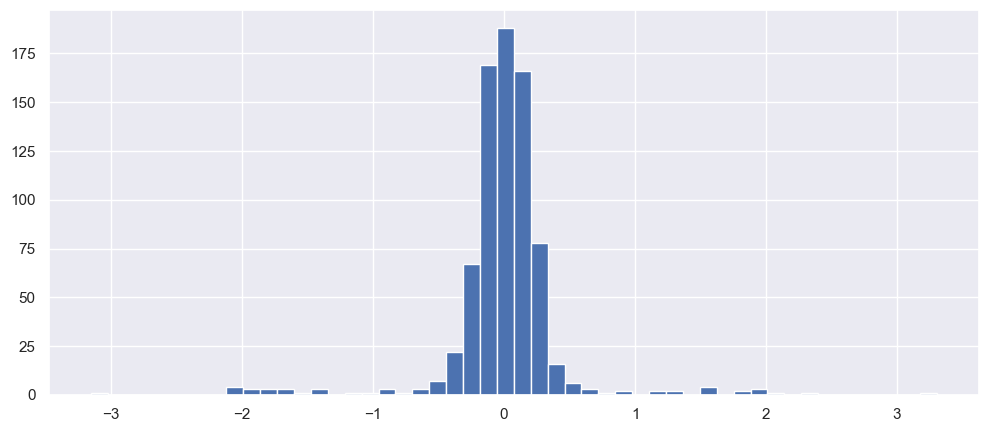

In [10]:
plt.figure(figsize=(12, 5));
plt.hist(df.loc[0, 'embedding'], bins=50);

In [11]:
emb_size = len(df.loc[0, 'embedding'].numpy()[0])
embeddng_array = np.zeros((len(df), emb_size))

for i in range(df.shape[0]):
    embeddng_array[i, :] = df.loc[i, 'embedding'].numpy()[0]

embeddng_array.shape

(15449, 768)

In [12]:
reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.0)
projected_embeddings = reducer.fit_transform(embeddng_array)

In [13]:
df['projected_x'] = projected_embeddings[:, 0]
df['projected_y'] = projected_embeddings[:, 1]

In [14]:
most_common_class = df.groupby(['class']).count()['text'].sort_values(ascending=False).head().index.values
most_common_class

array(['6-1', '6-2', '1-43', '1-72', '2-14'], dtype=object)

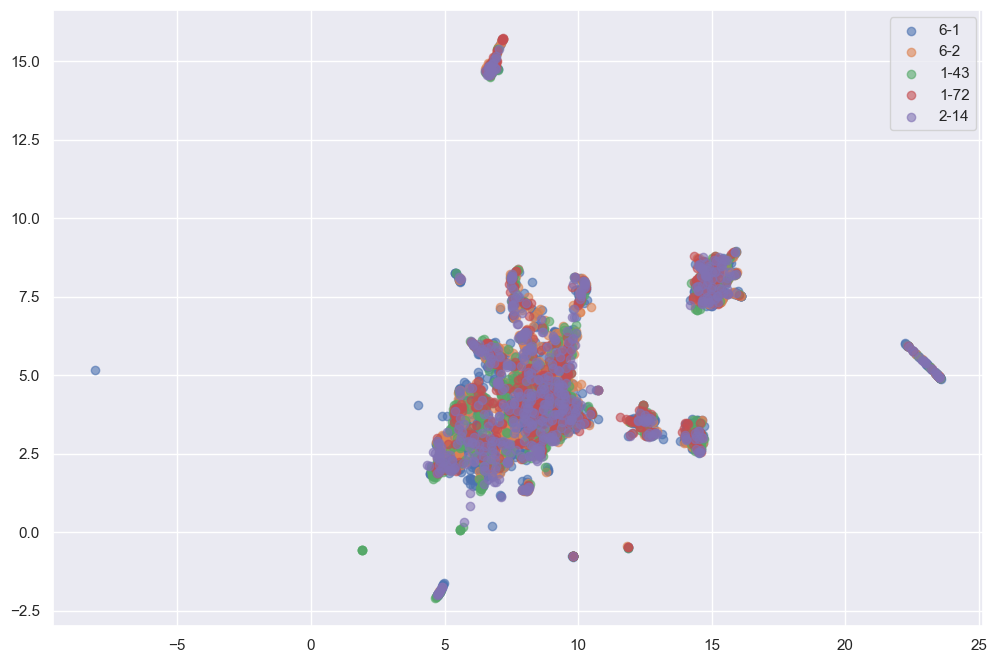

In [15]:
plt.figure(figsize=(12, 8));

for cls in most_common_class:
    plt.scatter(
        df[df['class'] == cls]['projected_x'], 
        df[df['class'] == cls]['projected_y'], 
        label=cls,
        alpha=0.6
    )
plt.legend();

In [16]:
X_train, X_val, y_train, y_val = train_test_split(embeddng_array, df['class'], test_size=0.33, random_state=RANDOM_STATE)

In [17]:
results = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])

In [18]:
svm = LinearSVC(random_state=RANDOM_STATE)
svm.fit(X_train, y_train)

predicts = svm.predict(X_val)

results.loc['SVM', 'accuracy'] = accuracy_score(y_val, predicts)
results.loc['SVM', 'precision'] = precision_score(y_val, predicts, average='weighted')
results.loc['SVM', 'recall'] = recall_score(y_val, predicts, average='weighted')
results.loc['SVM', 'f1-score'] = f1_score(y_val, predicts, average='weighted')

results

,accuracy,precision,recall,f1-score
SVM,0.420867,0.40892,0.420867,0.411564


In [19]:
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr.fit(X_train, y_train.values.ravel())

predicts = lr.predict(X_val)

results.loc['LogReg', 'accuracy'] = accuracy_score(y_val, predicts)
results.loc['LogReg', 'precision'] = precision_score(y_val, predicts, average='weighted')
results.loc['LogReg', 'recall'] = recall_score(y_val, predicts, average='weighted')
results.loc['LogReg', 'f1-score'] = f1_score(y_val, predicts, average='weighted')

results

,accuracy,precision,recall,f1-score
SVM,0.420867,0.40892,0.420867,0.411564
LogReg,0.440086,0.443554,0.440086,0.421699
